**Default fastai tta don't denorm prediction so works only for plain non spatial predictions:**

https://github.com/fastai/fastai/blob/d82d1f8fbd67e83f21eb128005646977dda70db6/fastai/vision/tta.py#L19



In [1]:
#default_exp segmentation.tta

In [2]:
%autosave 60 
import fastai; print(fastai.__version__)

Autosaving every 60 seconds
1.0.59.dev0


In [3]:
#export
from fastai.vision import *

In [4]:
from local.test import *

In [5]:
#export
def _flip_ud(x):
    "Flip `x` vertically."
    if isinstance(x, ImagePoints):
        x.flow.flow[...,1] *= -1
        return x
    return tensor(np.ascontiguousarray(np.array(x)[:,::-1].copy()))
flip_ud = TfmPixel(_flip_ud)

In [6]:
t = torch.zeros((1,256,256))
t[:,256//2:, 256//2:] = 1

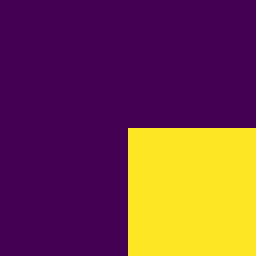

In [7]:
img = Image(t)
img

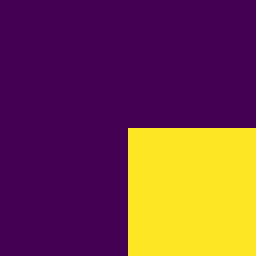

In [8]:
img = Image(t)
Image(torch.flip(flip_lr(img).data, dims=[-1]))

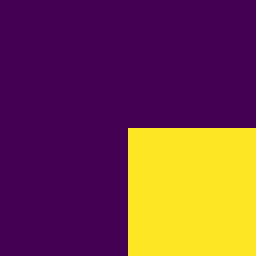

In [9]:
img = Image(t)
Image(torch.flip(flip_ud(img).data, dims=[-2]))

In [65]:
# export
from fastai.basic_train import _loss_func2activ
def _seg_tta_only_v1(learn:Learner, ds_type:DatasetType=DatasetType.Valid) -> Iterator[List[Tensor]]:
    "Computes the outputs for non-flip and flip_lr augmented inputs"
    dl = learn.dl(ds_type)
    ds = dl.dataset
    old = ds.tfms
    try:
        pbar = master_bar(range(2))
        for i in pbar:
            tfm = [] # to remove random crop resize aug
            if i: tfm.append(flip_lr(p=1.))
            ds.tfms = tfm
            yield get_preds(learn.model, dl, pbar=pbar, activ=_loss_func2activ(learn.loss_func))[0]
    finally: ds.tfms = old

Learner.seg_tta_only_v1 = _seg_tta_only_v1

In [66]:
# export
def _seg_tta_only_v2(learn:Learner, ds_type:DatasetType=DatasetType.Valid) -> Iterator[List[Tensor]]:
    "Computes the outputs for non-flip, flip_lr and flip_ud augmented inputs"
    dl = learn.dl(ds_type)
    ds = dl.dataset
    old = ds.tfms
    try:
        pbar = master_bar(range(3))
        for i in pbar:
            tfm = [] # to remove random crop resize aug
            if i == 1: tfm.append(flip_lr(p=1.))
            elif i == 2: tfm.append(flip_ud(p=1.))
            ds.tfms = tfm
            yield get_preds(learn.model, dl, pbar=pbar, activ=_loss_func2activ(learn.loss_func))[0]
    finally: ds.tfms = old

Learner.seg_tta_only_v2 = _seg_tta_only_v2

In [67]:
# flip_lr TTA preds
def _seg_TTA(learn:Learner, ds_type=DatasetType.Valid, updown=False):
    "Takes average of original and flip_lr"
    if not updown:
        orig_preds, flip_lr_preds = list(learn.seg_tta_only_v1(ds_type))
        flip_lr_preds = torch.stack([torch.flip(o, dims=[-1]) for o in flip_lr_preds], dim=0)
        avg_preds = (orig_preds + flip_lr_preds) / 2
    else:
        orig_preds, flip_lr_preds, flip_ud_preds = list(learn.seg_tta_only_v2(ds_type))        
        flip_lr_preds = torch.stack([torch.flip(o, dims=[-1]) for o in flip_lr_preds], dim=0)
        flip_ud_preds = torch.stack([torch.flip(o, dims=[-2]) for o in flip_ud_preds], dim=0)
        avg_preds = (orig_preds + flip_lr_preds + flip_ud_preds) / 3
    return avg_preds

Learner.segTTA = _seg_TTA

### `tests`

In [68]:
from local.segmentation.dataset import SemanticSegmentationData
from local.segmentation.metrics import *
# from local.segmentation.losses_binary import *
from local.segmentation.losses_multilabel import *
# test data creation
PATH = Path("/home/turgutluk/.fastai/data/camvid")
IMAGES = "images"
MASKS = "labels"
CODES = "codes.txt"
TRAIN, VALID, TEST = "train.txt", "valid.txt", "test.txt"
ssdata = SemanticSegmentationData(PATH, IMAGES, MASKS, CODES, TRAIN,
                                  VALID, TEST, sample_size=None, bs=4, size=112)
data = ssdata.get_data()

In [69]:
learn = unet_learner(data, models.resnet34); 
learn.metrics = [partial(foreground_acc, void_code=30)]
learn.path = Path(".")
learn.loss_func = lovasz_softmax

In [70]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,foreground_acc,time
0,0.834825,0.760755,0.729466,00:18
1,0.774869,0.724254,0.765455,00:20
2,0.727659,0.701049,0.768020,00:19
3,0.685124,0.672644,0.790862,00:19
4,0.663146,0.649177,0.791330,00:20


In [71]:
metric = learn.metrics[0]

In [76]:
preds, targs = learn.get_preds()
score = metric(preds, targs)

In [77]:
tta_v1_preds = learn.segTTA(updown=False)
assert metric(tta_v1_preds, targs) > score

In [78]:
tta_v2_preds = learn.segTTA(updown=True)
assert metric(tta_v2_preds, targs) > score

### export

In [6]:
from local.notebook.export import notebook2script
notebook2script(all_fs=True)

Converted 00_test.ipynb.
Converted 01_script.ipynb.
Converted 02_scheduler.ipynb.
Converted 03_callbacks.ipynb.
Converted 04_optimizers_optimizers.ipynb.
Converted 10_segmentation_dataset.ipynb.
Converted 11_segmentation_losses_mulitlabel.ipynb.
Converted 11b_segmentation_losses_binary.ipynb.
Converted 12_segmentation_metrics.ipynb.
Converted 13_segmentation_models.ipynb.
Converted 14_segmentation_postprocess.ipynb.
Converted 15_segmentation_tta.ipynb.
Converted 15_segmentation_utils.ipynb.
Converted segmentation_training.ipynb.


### fin